In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.float_format", "{:,.2f}".format)
pd.set_option("display.max_columns", None)
import shap
from classes import Paths

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool

<div class="alert alert-warning">

**TASK**

<div class="alert alert-info">

We took our dataset, extracted the top 5 important features from it, and added the same number of random ones, anonymized them, and got 10 columns/features. Try to make your own rating of signs by importance. We will check only the first 5, but in the response you can specify all 10 values with numbers (feature_0 corresponds to 0).

**Answer example**: answer_list = [5, 1, 9, 2, 8] . The answer is counted if all the correct features are in the list. The order of the features is important!

In [2]:
paths = Paths()
path = paths.feature_selection_sample
df = pd.read_csv(path)
df.head(10)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
0,2015,163.00,-1.45,0.50,332,-0.02,170,-9,0.10,50.34,engine_ignition
1,2014,108.45,2.23,0.40,425,-0.85,173,16,0.10,44.37,break_bug
2,2010,167.74,-8.02,-0.80,50,0.13,171,-9,0.10,44.90,engine_check
3,2018,167.00,-0.20,2.00,224,-0.99,173,-2,0.52,44.77,engine_check
4,2019,183.00,14.67,0.80,351,0.61,170,13,0.10,45.24,another_bug
5,2016,170.74,8.28,-0.10,256,-0.05,172,-8,0.00,49.24,electro_bug
6,2009,179.89,9.09,-2.00,441,-0.20,173,11,0.10,50.39,engine_fuel
7,2010,200.00,6.80,-0.20,421,-0.77,174,-11,0.00,50.61,electro_bug
8,2009,183.64,2.21,-0.00,476,-0.87,174,-14,0.00,48.66,electro_bug
9,2016,175.56,3.47,-0.20,205,0.93,170,10,0.10,50.67,engine_fuel


In [3]:
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
clf = model.fit(X_train, y_train)
clf.feature_importances_

array([0.03700492, 0.31646911, 0.06526485, 0.05295221, 0.05609698,
       0.05682731, 0.04674282, 0.05111947, 0.131395  , 0.18612731])

<div class="alert alert-info">

### **1. Feature Importance**

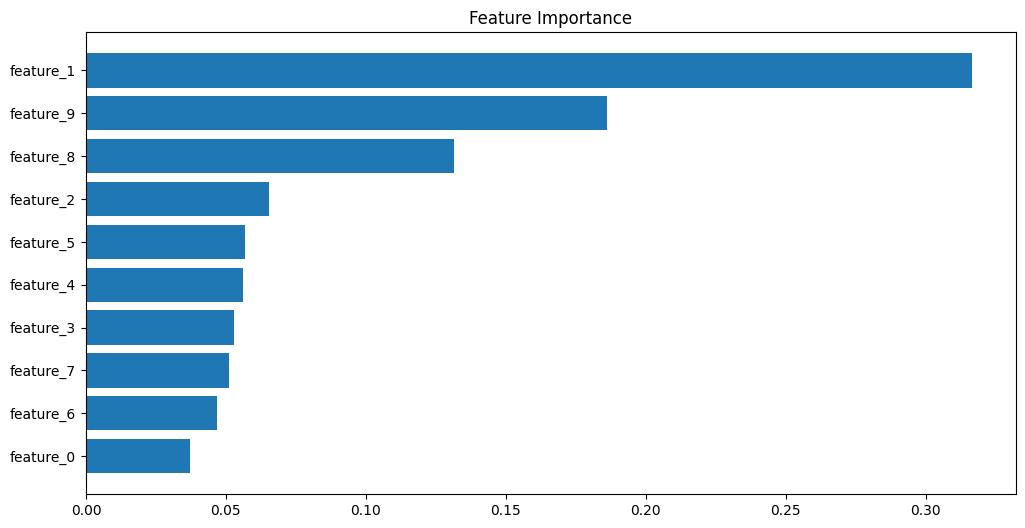

In [4]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

<div class="alert alert-success">

**Answer: [1 ,9 ,8 ,2 ,5]**

<div class="alert alert-info">

### **2. Permutation Importance**

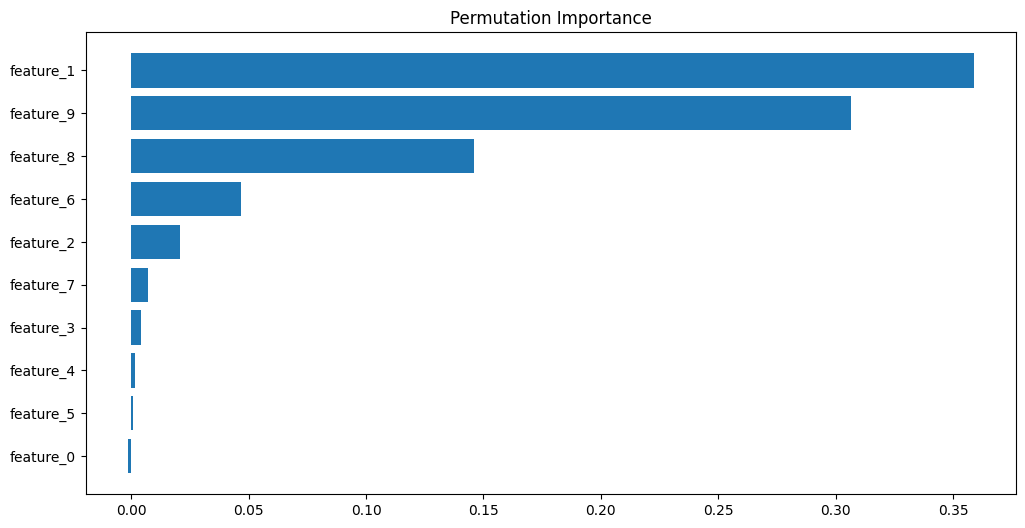

In [5]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

<div class="alert alert-info">

### **3. SHAP**

In [6]:
drop_cols = ['target']
cat_cols = []

X = df.drop(drop_cols, axis=1, errors = 'ignore')
y = df['target'].fillna(0)

In [7]:
model_cb = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1)
model_cb.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.10885
0:	learn: 1.9397215	test: 1.9473294	best: 1.9473294 (0)	total: 60.3ms	remaining: 1m
100:	learn: 0.4678663	test: 0.6483020	best: 0.6483020 (100)	total: 261ms	remaining: 2.32s
200:	learn: 0.3304501	test: 0.6373796	best: 0.6366906 (199)	total: 437ms	remaining: 1.74s
300:	learn: 0.2467960	test: 0.6428317	best: 0.6361299 (254)	total: 613ms	remaining: 1.42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6361299133
bestIteration = 254

Shrink model to first 255 iterations.


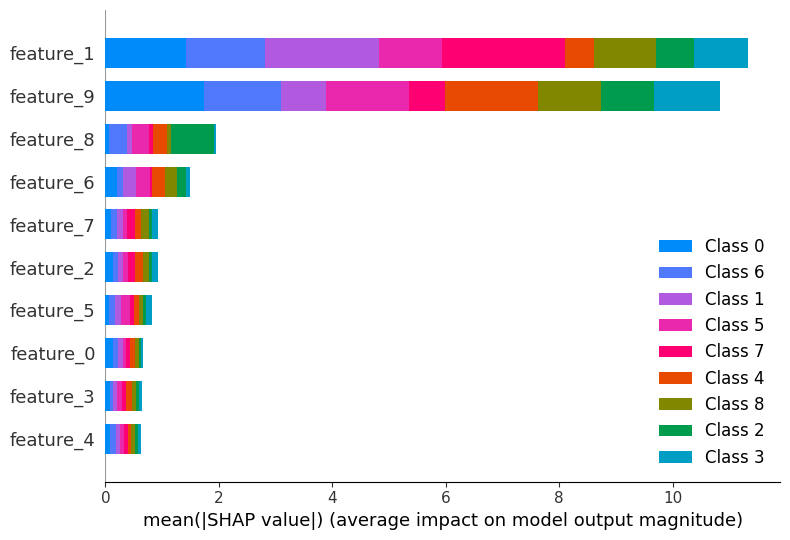

In [8]:
explainer = shap.TreeExplainer(model_cb)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25, plot_type='bar', feature_names=X_test.columns.values);
